# Random Forest Model
Code in this file goes over whole process of creating Random Forest model

## Importing packages

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import resample
import pandas as pd
import joblib

## Data Load

In [3]:
# Loading the data
df_no_risk = pd.read_excel("dataset.xlsx", sheet_name="data0")
df_risk = pd.read_excel("dataset.xlsx", sheet_name="data1")

## Formating

In [4]:
def featuring(df):
    df["Month"] = pd.Categorical(df["Month"], categories=range(1, 13), ordered=True)
    df[["WindSpeed", "Temperature", "Humidity",
        "Pressure", "Precipitation", "PM2.5", "PM10"]] = df[["WindSpeed", "Temperature", "Humidity",
        "Pressure", "Precipitation", "PM2.5", "PM10"]].astype(float)
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
    return df

In [5]:
def create_sequence_and_label(df, label): # Create sequences of 3 rows and assign a label
    sequences=[] # List to store sequences
    i = 0 # Initialize index
    while i < len(df): # Loop through the dataframe
        seq = df.iloc[i:i + 3].values.flatten() # Get 3 rows and flatten them into a single row
        sequences.append(seq) 
        i = i+3 # Move to the next sequence
    return pd.DataFrame(sequences).assign(label=label) # Assign the label

df_no_risk = featuring(df_no_risk)
df_risk = featuring(df_risk) 

# Create sequences for both classes
df1 = create_sequence_and_label(df_no_risk, label=0)
df2 = create_sequence_and_label(df_risk, label=1)

original_cols = df_no_risk.columns.tolist() # Get the original column names

# Rename columns for 3-day sequences
column_names = (
    original_cols +
    [f"{col}_2" for col in original_cols] +
    [f"{col}_3" for col in original_cols] +
    ["label"]
)
df1.columns = column_names
df2.columns = column_names

In [6]:
def new_features(df):
    df["PM10_avg"] = df[["PM10", "PM10_2", "PM10_3"]].mean(axis=1)
    df["PM10_std"] = df[["PM10", "PM10_2", "PM10_3"]].std(axis=1)
    df["PM10_CV"] = df["PM10_std"] / df["PM10_avg"]
    df["PM2.5_avg"] = df[["PM2.5", "PM2.5_2", "PM2.5_3"]].mean(axis=1)
    df["PM2.5_std"] = df[["PM2.5", "PM2.5_2", "PM2.5_3"]].std(axis=1)
    df["PM2.5_CV"] = df["PM2.5_std"] / df["PM2.5_avg"]
    df["WindSpeed_trend"] = df["WindSpeed_3"] - df["WindSpeed"]
    df["Humidity_diff"] = df["Humidity_3"] - df["Humidity"]
    df["PM2.5_trend"] = (df["PM2.5_3"] - df["PM2.5"])/ df["PM2.5"]
    df["PM10_trend"] = (df["PM10_3"] - df["PM10"])/ df["PM10"]
    df.drop(columns=["PM10", "PM10_2", "PM10_3", "PM2.5", "PM2.5_2", "PM2.5_3", "IsHoliday", "IsHoliday_2", "IsHoliday_3"], inplace=True)
    return df

In [7]:
df1 = new_features(df1)
df2 = new_features(df2)

## Sampling

In [8]:
# Balancing the dataset
df2_oversampling = resample(df2, # Resampling label 1
                            replace=True, 
                            n_samples=338, # Number of samples to generate
                            random_state=42)  # Random state for reproducibility
# Concatenate both datasets
df_balanced = pd.concat([df1, df2_oversampling])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Creating X and y variables for the model
X = df_balanced.drop('label', axis=1)
y = df_balanced['label']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% for testing
                                                    random_state=42
                                                    ) 

## Parameter tuning

In [9]:
"""# Creating the Random Forest model with hyperparameter tuning
param_dist = {
    'n_estimators': randint(10, 1000), # Randomly choose between 10 and 1000 trees
    'max_depth': [None, 10, 20, 30, 50], # Randomly choose between None and various depths
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 5], # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None], # Number of features to consider when looking for the best split
    'bootstrap': [True, False], # Whether bootstrap samples are used when building trees
    'class_weight': [None, 'balanced', "balanced_subsample"] # Weights associated with classes in the form {class_label: weight}
}

# RandomizedSearchCV for hyperparameter tuning
rf_model = RandomForestClassifier(random_state=42)

rand_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=60,  # Number of different combinations to try
    cv=5, # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    scoring='f1'  # Use F1 score as the scoring metric
)

# Fit the model
rand_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best params:", rand_search.best_params_)
print("Best score:", rand_search.best_score_)"""

'# Creating the Random Forest model with hyperparameter tuning\nparam_dist = {\n    \'n_estimators\': randint(10, 1000), # Randomly choose between 10 and 1000 trees\n    \'max_depth\': [None, 10, 20, 30, 50], # Randomly choose between None and various depths\n    \'min_samples_split\': [2, 5, 10], # Minimum number of samples required to split an internal node\n    \'min_samples_leaf\': [1, 2, 4, 5], # Minimum number of samples required to be at a leaf node\n    \'max_features\': [\'sqrt\', \'log2\', None], # Number of features to consider when looking for the best split\n    \'bootstrap\': [True, False], # Whether bootstrap samples are used when building trees\n    \'class_weight\': [None, \'balanced\', "balanced_subsample"] # Weights associated with classes in the form {class_label: weight}\n}\n\n# RandomizedSearchCV for hyperparameter tuning\nrf_model = RandomForestClassifier(random_state=42)\n\nrand_search = RandomizedSearchCV(\n    estimator=rf_model,\n    param_distributions=param

## Model

In [10]:
# Creating the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200,
                                  class_weight = None,
                                  max_depth = 30,
                                  max_features = "log2",
                                  min_samples_leaf = 1,
                                  min_samples_split = 2,
                                  bootstrap=True,
                                  random_state = 42) # Random state for reproducibility

# Fitting the model to the training data
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9705882352941176
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        73
           1       0.95      0.98      0.97        63

    accuracy                           0.97       136
   macro avg       0.97      0.97      0.97       136
weighted avg       0.97      0.97      0.97       136



In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=5)
print(f"CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

CV Accuracy: 0.941 ± 0.028


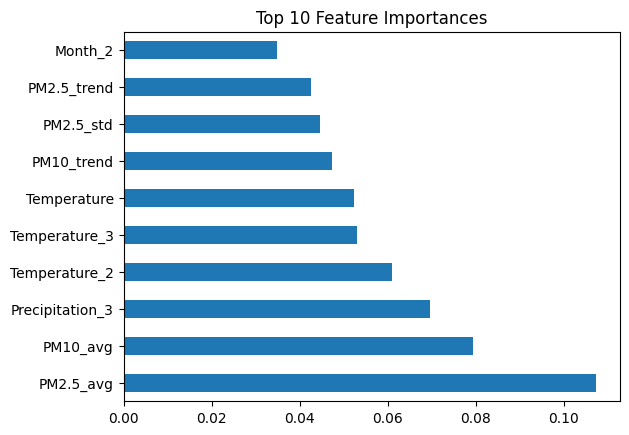

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

feat_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

feat_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importance.sort_values(ascending=True, inplace=True)
feat_importance

IsWeekend_3        0.001777
IsWeekend_2        0.002482
IsWeekend          0.002675
Year               0.008455
Precipitation      0.008767
Year_3             0.008802
Year_2             0.009382
WindSpeed_2        0.012947
Precipitation_2    0.012994
Humidity_diff      0.014511
Humidity_2         0.015790
Humidity           0.016414
PM2.5_CV           0.018982
WindSpeed          0.019470
Humidity_3         0.020036
Pressure           0.020977
Pressure_2         0.021364
WindSpeed_trend    0.023932
PM10_CV            0.024854
Month              0.025119
Month_3            0.025561
WindSpeed_3        0.027142
PM10_std           0.032098
Pressure_3         0.033561
Month_2            0.034785
PM2.5_trend        0.042558
PM2.5_std          0.044694
PM10_trend         0.047244
Temperature        0.052334
Temperature_3      0.053023
Temperature_2      0.060930
Precipitation_3    0.069612
PM10_avg           0.079423
PM2.5_avg          0.107304
dtype: float64

In [14]:
probs = rf_model.predict_proba(X_test)[:, 1]  # get predicted probabilities for class 1
threshold = 0.3  # lower than 0.5 to be more sensitive
preds_adjusted = (probs >= threshold).astype(int)

In [15]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
# Suppose you have your test labels and adjusted predictions:
y_true = y_test
y_pred = preds_adjusted  # from thresholding probabilities

# Full classification report
print(classification_report(y_true, y_pred))

# Or calculate metrics individually
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")

              precision    recall  f1-score   support

           0       0.98      0.75      0.85        73
           1       0.78      0.98      0.87        63

    accuracy                           0.86       136
   macro avg       0.88      0.87      0.86       136
weighted avg       0.89      0.86      0.86       136

Precision: 0.775
Recall:    0.984
F1-score:  0.867


In [16]:
joblib.dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']